In [55]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from sklearn.linear_model import Lasso
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings
warnings.filterwarnings("ignore")

Import all the data

In [56]:
train_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
holev = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
oil = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
stores = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
transactions = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")
pd.set_option('display.max_columns',None)

In [57]:
len(test_df)

28512

In [58]:
IQR = np.percentile(train_df['sales'],75) - np.percentile(train_df['sales'], 25)
Lower_Outlier = np.percentile(train_df['sales'],25) - 1.5 * IQR
Higher_Outlier = np.percentile(train_df['sales'],75) + 1.5 * IQR

In [59]:
train_df = train_df[(train_df['sales'] > Lower_Outlier) & (train_df['sales'] < Higher_Outlier)]

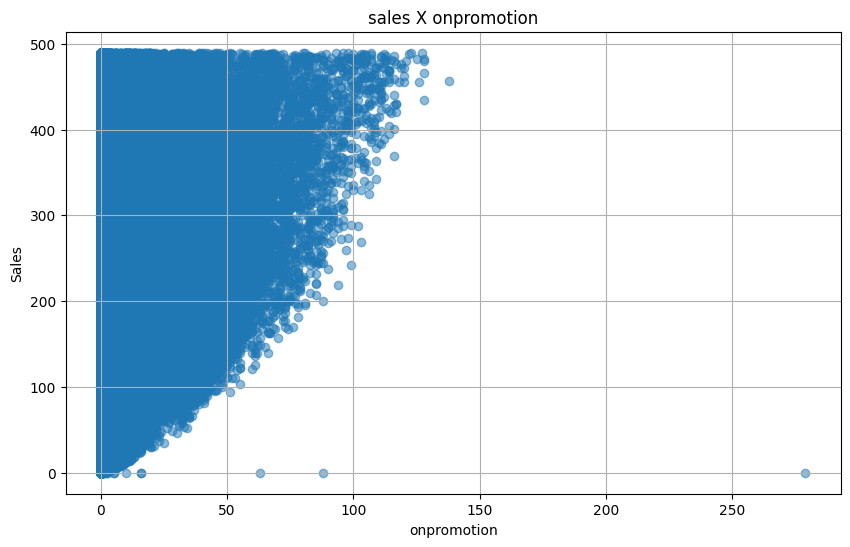

In [60]:
plt.figure(figsize=(10, 6))
plt.scatter(train_df['onpromotion'], train_df['sales'], alpha=0.5)
plt.title(f'sales X onpromotion')
plt.xlabel(f'onpromotion')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

Let's create different variables from datetime

In [61]:
for dataframe in [train_df, test_df]:
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    dataframe['day_week'] = dataframe['date'].dt.day_of_week
    dataframe['day'] = dataframe['date'].dt.day
    dataframe['month'] = dataframe['date'].dt.month
    dataframe['year'] = dataframe['date'].dt.year

Let's Merge all the datasets

In [62]:
#we use the store number in order to get all the informations into train and test set
train_df = train_df.merge(stores, on = 'store_nbr', how = 'left')
test_df = test_df.merge(stores, on = 'store_nbr', how = 'left')

In [63]:
holev['date'] = pd.to_datetime(holev['date'])

# Holidays
Since the holidays are of 3 different kind (National, Regional and Ciy) we addss the problem by getting all the national holidays and then merge it by the date.
Same process for regional and city.

In [64]:
df_national_holidays = holev[holev['locale'] == 'National']
train_df = train_df.merge(df_national_holidays[['date', 'type']], on='date', how='left', suffixes=('', '_national'))
test_df = test_df.merge(df_national_holidays[['date', 'type']], on='date', how='left', suffixes=('', '_national'))

In [65]:
df_regional_holidays = holev[holev['locale'] == 'Regional']
train_df = train_df.merge(df_regional_holidays[['date', 'type', 'locale_name']], 
                          left_on=['date', 'state'], right_on=['date', 'locale_name'], 
                          how='left', suffixes=('', '_regional'))
test_df = test_df.merge(df_regional_holidays[['date', 'type', 'locale_name']], 
                          left_on=['date', 'state'], right_on=['date', 'locale_name'], 
                          how='left', suffixes=('', '_regional'))

In [66]:
df_local_holidays = holev[holev['locale'] == 'Local']
train_df = train_df.merge(df_local_holidays[['date', 'type', 'locale_name']], 
                          left_on=['date', 'city'], right_on=['date', 'locale_name'], 
                          how='left', suffixes=('', '_local'))
test_df = test_df.merge(df_local_holidays[['date', 'type', 'locale_name']], 
                          left_on=['date', 'city'], right_on=['date', 'locale_name'], 
                          how='left', suffixes=('', '_local'))

In [67]:
train_df['holiday_type'] = train_df['type_national'].combine_first(train_df['type_regional']).combine_first(train_df['type_local'])
test_df['holiday_type'] = test_df['type_national'].combine_first(test_df['type_regional']).combine_first(test_df['type_local'])

In [68]:
train_df.drop(columns=['type_national', 'type_regional', 'type_local', 'locale_name','locale_name_local'], inplace=True)
test_df.drop(columns=['type_national', 'type_regional', 'type_local', 'locale_name','locale_name_local'], inplace=True)

In [69]:
train_df['holiday_type'] = train_df['holiday_type'].fillna('Work Day')
test_df['holiday_type'] = test_df['holiday_type'].fillna('Work Day')

In [70]:
train_df.loc[train_df['holiday_type'] == 'Transfer', 'holiday_type'] = 'Work Day'
train_df.loc[train_df['holiday_type'] == 'Additional', 'holiday_type'] = 'Holiday'
train_df.loc[train_df['holiday_type'] == 'Event', 'holiday_type'] = 'Holiday'
train_df.loc[train_df['holiday_type'] == 'Bridge', 'holiday_type'] = 'Holiday'

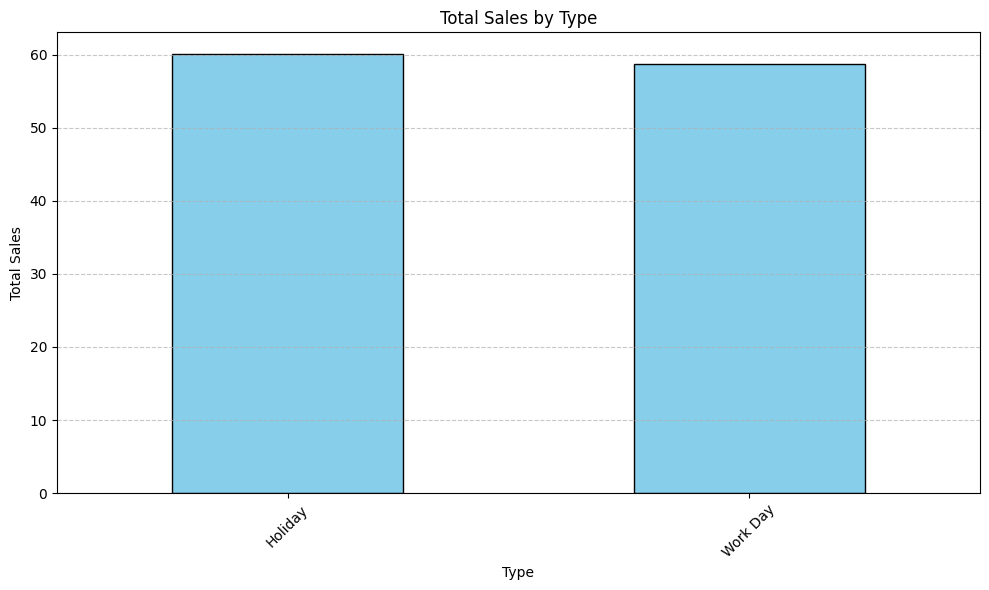

In [71]:
sales_totals = train_df.groupby('holiday_type')['sales'].mean()

# Creare il grafico a barre
plt.figure(figsize=(10, 6))
sales_totals.plot(kind='bar', color='skyblue', edgecolor='black')

# Personalizzazione del grafico
plt.xlabel('Type')
plt.ylabel('Total Sales')
plt.title('Total Sales by Type')
plt.xticks(rotation=45)  # Ruota le etichette dell'asse x per migliorare la leggibilità
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Aggiungi una griglia sull'asse y

# Mostrare il grafico
plt.tight_layout()  # Ottimizza il layout per evitare sovrapposizioni
plt.show()

In [72]:
unique_holiday_types = train_df['family'].unique()

# Numero di subplot
n_subplots = len(unique_holiday_types)

# Impostare la dimensione della figura con maggiore altezza
plt.figure(figsize=(10, 5 * n_subplots))

# Creare un subplot per ciascun valore unico di 'holiday_type'
for i, holiday_type in enumerate(unique_holiday_types):
    # Filtrare i dati per il tipo di holiday
    filtered_df = train_df[train_df['family'] == holiday_type]
    
    # Creare un subplot
    plt.subplot(n_subplots, 1, i + 1)
    plt.scatter(filtered_df['onpromotion'], filtered_df['sales'], alpha=0.5)
    plt.title(f'Sales vs Onpromotion ({holiday_type})')
    plt.xlabel('Onpromotion')
    plt.ylabel('Sales')
    plt.grid(True)

# Mostrare il grafico
plt.tight_layout()
plt.show()

# Creating Dummies

In [ ]:
test_ids = test_df['id']

In [20]:
train_df = train_df.drop(columns = ['id','day','year'],errors = 'ignore')
test_df = test_df.drop(columns = ['id','day','year'],errors = 'ignore')

In [21]:
train_df['is_train'] = 1
test_df['is_train'] = 0

In [22]:
# Combina i dati
combined_data = pd.concat([train_df, test_df])

In [23]:
# Applica pd.get_dummies
combined_dummies = pd.get_dummies(combined_data, columns=['store_nbr', 'family', 'type', 'holiday_type', 'city', 'state', 'cluster', 'day_week', 'month'], drop_first=True, dtype = float)

In [24]:
# Separa i dati
train_df = combined_dummies[combined_dummies['is_train'] == 1].drop(columns=['is_train'])
test_df = combined_dummies[combined_dummies['is_train'] == 0].drop(columns=['is_train'])

In [25]:
len(test_df)

28512

In [26]:
test_df = test_df.drop(columns = 'sales')

# Lag features

In [27]:
#helper function to create lag features
def add_weekly_lag_features(lag,feature,data,new_feature):
    for l in lag:
        data[str(new_feature+'_'+str(l))] = data[str(feature)].shift(l*7)
    return data

In [28]:
try:
    train_df.set_index('date', inplace=True)
except: 
    pass

In [29]:
df_weekly = train_df['sales'].resample('W').mean().dropna()

# Scaling

In [30]:
#scaler_x = StandardScaler()
#scaler_y = StandardScaler()

In [31]:
lags = [1,2]

In [32]:
train_df = add_weekly_lag_features(lags,'sales',train_df,'lag')
train_df = train_df.dropna()

# Corregplot
Let's visualize the lags by week

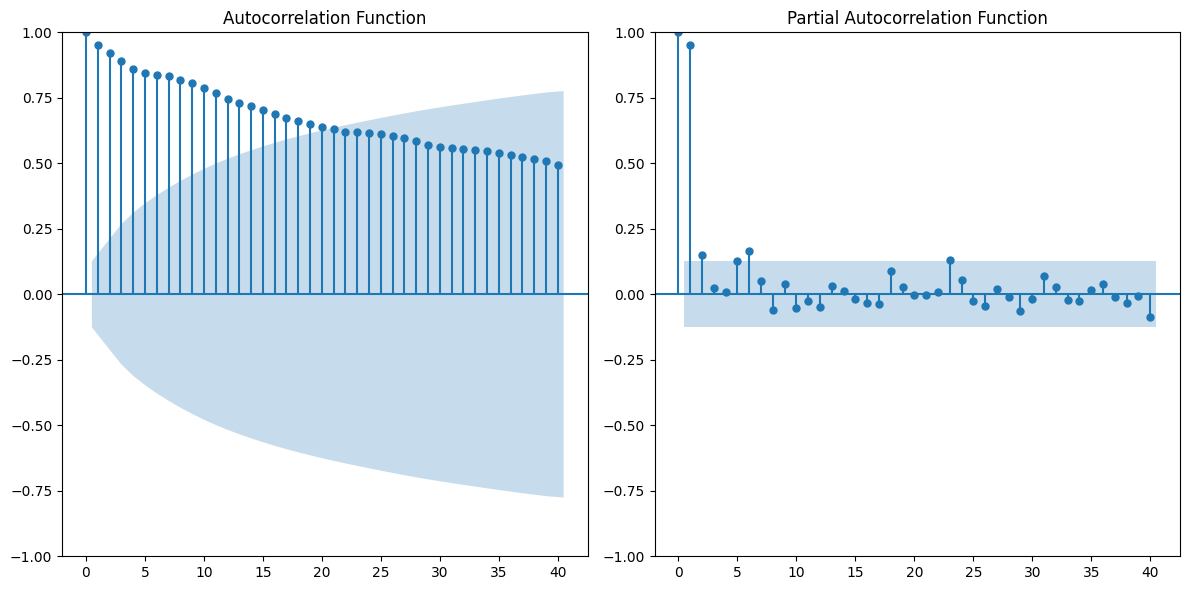

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df_weekly, lags=40, ax=plt.gca())
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(df_weekly, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [34]:
X, y = train_df.drop(columns = ['sales'],errors = 'ignore'), train_df['sales']

In [35]:
#X['onpromotion'] = scaler_x.fit_transform(X[['onpromotion']])
#y = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [36]:
#X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2,random_state=123)

In [37]:
# Build Keras Sequential model
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X.shape[1]))  # Primo layer denso
model.add(Dense(64, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mae')

In [38]:
# Train the model
history = model.fit(X, y, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
  106/39995 ━━━━━━━━━━━━━━━━━━━━ 57s 1ms/step - loss: 58.0082 

I0000 00:00:1721979162.703432     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


39995/39995 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 25.8361
Epoch 2/10
39995/39995 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 17.2860
Epoch 3/10
39995/39995 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 16.2918
Epoch 4/10
39995/39995 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 15.7851
Epoch 5/10
39995/39995 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 15.4480
Epoch 6/10
39995/39995 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 15.2260
Epoch 7/10
39995/39995 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 15.0230
Epoch 8/10
39995/39995 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 14.8744
Epoch 9/10
39995/39995 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 14.7950
Epoch 10/10
39995/39995 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 14.6846


In [39]:
#y_val_pred = model.predict(X_val)

In [40]:
#y_val_pred = scaler_y.inverse_transform(np.array(y_val_pred).reshape(-1, 1))

In [41]:
#y_val_pred[y_val_pred < 0] = 0

In [42]:
#y_val = scaler_y.inverse_transform(np.array(y_val).reshape(-1, 1))

In [43]:
#mae = mean_squared_log_error(y_val, y_val_pred)
#print(mae)

In [44]:
#helper function for iterative forecast. 
def iterative_forecast(model, training, test):
    predictions = []
    
    # let's create the lag columns
    for lag in [1, 2]:
        test[f'lag_{lag}'] = None
    
    # Iteration on the dataset
    for i in range(len(test)):
        for lag in [1, 2]:
            if i < lag * 7:
                # here we use the real values in the training set
                lag_value = training['sales'].iloc[len(training) - lag * 7 + i] if (len(training) - lag * 7 + i) >= 0 else None
            else:
                # here we use the predicted values
                lag_value = predictions[i - lag * 7] if (i - lag * 7) >= 0 else None
            
            test.at[i, f'lag_{lag}'] = lag_value
        
        # let's create the dataframe for the current row
        current_lag = test.iloc[i:i+1].drop(columns=['sales'], errors='ignore')
        
        # let's predict and append the result to the list
        value = model.predict(current_lag)[0] 
        predictions.append(value)
        
    return predictions

In [45]:
test_df = test_df.drop(columns = ['id','date'], errors = 'ignore')

In [ ]:
predictions = iterative_forecast(model, train_df, test_df)

In [47]:
#predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))

In [49]:
predictions = np.array(predictions)

In [51]:
for j in range(len(predictions)):
    if predictions[j] < 0:
        predictions[j] = 0
    else:
        pass

In [52]:
test_ids = np.ravel(test_ids)
predictions = np.ravel(predictions)

In [53]:
submission = pd.DataFrame({'id': test_ids, 'sales': predictions})
submission.to_csv('submission.csv', index=False)